### Banking Analytics Group Project——Foreign Exchange AI Agency Service (Demo)
A0218936U Li Yongzhen

### Purpose
This notebook serves to show a demo of our foreign exchange agency service.
We generate a 3-month contract(2017-01~2017-03) on exchanging Euros to USD dollars and simulate the auto-implementation of USD buying.
The objective USD buying amount is set as $10000. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

### Forecast Outcome
File prediction_weekly.csv contains the weekly prediction of eur-usd exchange rate. File EURUSD_M15_predictions.csv contains the 15-minute-interval prediction of eur-usd exchange rate. The weekly prediction is obtained before the start of the contract, and the 15-minute-interval prediction is predicted on an up-to-date rolling basis.

In [2]:
fore_df = pd.read_csv('prediction.csv')

In [3]:
fore_df.head()

,Unnamed: 0,Date,EURO_USD,Prediction,lower_bounds,upper_bounds
0,574,2017-01-02,1.050786,1.051443,1.023636,1.079250
1,575,2017-01-09,1.060686,1.054140,1.008944,1.099337
2,576,2017-01-16,1.064371,1.056633,0.997838,1.115428
3,577,2017-01-23,1.070700,1.059047,0.989111,1.128982
4,578,2017-01-30,1.074371,1.061417,0.981997,1.140838


In [4]:
fore_df.drop(columns=['Unnamed: 0'],inplace=True)

In [5]:
fore_df.set_index('Date',inplace=True)

In [6]:
fore_df.index

Index(['2017-01-02', '2017-01-09', '2017-01-16', '2017-01-23', '2017-01-30',
       '2017-02-06', '2017-02-13', '2017-02-20', '2017-02-27', '2017-03-06',
       '2017-03-13', '2017-03-20', '2017-03-27'],
      dtype='object', name='Date')

<AxesSubplot:xlabel='Date'>

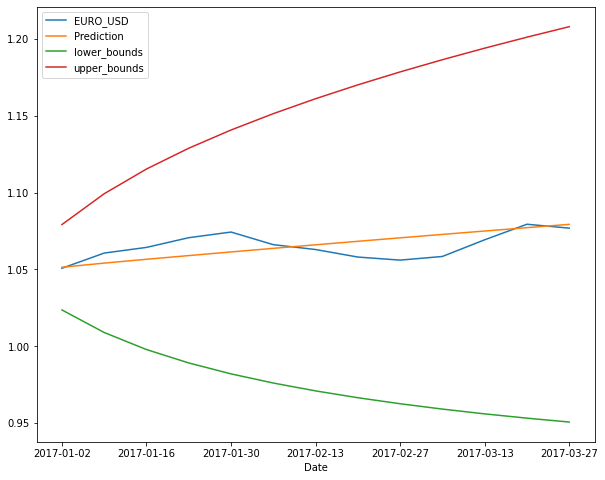

In [7]:
fore_df.plot(figsize=(10,8))

In [8]:
from sklearn.metrics import mean_squared_error

def mape(y_true,y_pred):
    return 100*np.mean(np.abs(y_true-y_pred)/y_true)

y_true = fore_df['EURO_USD'].values
y_pred = fore_df['Prediction'].values

print("RMSE: ", mean_squared_error(y_true,y_pred,squared=False))
print("MAPE: ", mape(y_true,y_pred))


RMSE:  0.008720053473342307
MAPE:  0.6837596341240394


In [9]:
pred_df = pd.read_csv('EURUSD_M15_predictions.csv')

In [10]:
pred_df.head()

,timestamp,predicted,close,low,high,diff,correct,percentage_error,error_to_range,lag1_mape
0,2017-01-02 05:00:00,1.052039,1.05171,1.05171,1.05144,0.000329,False,0.031252,1.217316,-100.000000
1,2017-01-02 05:15:00,1.052071,1.05151,1.05171,1.05138,0.000561,False,0.053395,1.701387,0.031252
2,2017-01-02 05:30:00,1.052083,1.05180,1.05188,1.05130,0.000283,False,0.026897,0.487762,0.042323
3,2017-01-02 05:45:00,1.052094,1.05184,1.05214,1.05142,0.000254,True,0.024136,0.352596,0.037181
4,2017-01-02 06:00:00,1.052134,1.05179,1.05190,1.05130,0.000344,False,0.032688,0.573007,0.033920


In [11]:
#lag1_mape=[-1]
#pct_errs=pred_df.percentage_error.values
#for i in range(1,len(pct_errs)):
    #lag1_mape.append(sum(pct_errs[:i])/i)
#pred_df['lag1_mape']=np.array(lag1_mape)

In [12]:
#pred_df.to_csv('EURUSD_M15_predictions.csv')

In [13]:
#pred_df.percentage_error=pred_df.percentage_error*100
#pred_df.lag1_mape = pred_df.lag1_mape*100

In [14]:
pred_df.set_index('timestamp',inplace=True)

In [15]:
pred_df.index.values[-1]

'2017-03-31 23:30:00'

### Set the Contract
We offered two plans for settng the goal of a contract.Plan A is more conservative, and can be used both when predicted price is better than current price and when predicted price is worse than current price. Plan B is more progressive, and should be used only when predicted price is better than current price.

plan A: objective exchange rate = predicted exchange rate - last period std * current exchange rate

In [16]:
weekly_df = pd.read_csv('Weekly_Value.csv')
weekly_df.head()

,Date,EURO_USD
0,27-Mar-17,1.076917
1,20-Mar-17,1.079457
2,13-Mar-17,1.069329
3,6-Mar-17,1.058471
4,27-Feb-17,1.056086


In [17]:
weekly_df.Date = pd.to_datetime(weekly_df.Date)
weekly_df = weekly_df.set_index('Date')
weekly_df = weekly_df.sort_index(ascending=True)
weekly_df.head()

,EURO_USD
Date,
2006-01-02,1.202157
2006-01-09,1.206571
2006-01-16,1.208414
2006-01-23,1.223043
2006-01-30,1.207729


In [18]:
lst_3m_df = weekly_df[weekly_df.index>='2016-10-01']
lst_3m_df = lst_3m_df[lst_3m_df.index<'2017-01-01']
lst_3m_df.head()

,EURO_USD
Date,
2016-10-03,1.117329
2016-10-10,1.104329
2016-10-17,1.094343
2016-10-24,1.091157
2016-10-31,1.105843


In [19]:
contract_usd = 10000
cur_fr=lst_3m_df.EURO_USD.values[-1]
std_lst3m = np.nanstd(lst_3m_df.EURO_USD.values)
pred_3m = np.sort(fore_df.Prediction.values.tolist())[-2]# use the second maximum as buffer 

obj_fr_1 = pred_3m - std_lst3m * cur_fr
contract_eur_1 = contract_usd/obj_fr_1
current_eur_1 = contract_usd/cur_fr
commission_fee_1 = np.maximum(std_lst3m*contract_eur_1*0.1,contract_eur_1*0.0015)
print('Amount to Buy: 10000 USD')
print('Execution Time Frame: from 2017-01-01 to 2017-03-31')
print('Guaranteed Exchange Rate: {} '.format(np.round(obj_fr_1,6)))
print('Authorizd Euro: {} EURO'.format(np.ceil(contract_eur_1)))
print('If Buy Now: {} EURO'.format(np.ceil(current_eur_1)))
print('Commission Fee: {} EURO'.format(np.round(commission_fee_1,2)))

Amount to Buy: 10000 USD
Execution Time Frame: from 2017-01-01 to 2017-03-31
Guaranteed Exchange Rate: 1.052134 
Authorizd Euro: 9505.0 EURO
If Buy Now: 9541.0 EURO
Commission Fee: 22.75 EURO


plan B: objective exchange rate = 0.75 * predicted exchange rate + 0.25 * current exchange rate

In [20]:
obj_fr_2 = 0.75 * pred_3m + 0.25 * cur_fr
contract_eur_2 = contract_usd/obj_fr_2
current_eur_2 = contract_usd/cur_fr
commission_fee_2 = np.maximum(std_lst3m*contract_eur_2*0.1,contract_eur_2*0.0015)
print('Amount to Buy: 10000 USD')
print('Execution Time Frame: from 2017-01-01 to 2017-03-31')
print('Guaranteed Exchange Rate: {} '.format(np.round(obj_fr_2,6)))
print('Authorizd Euro: {} EURO'.format(np.ceil(contract_eur_2)))
print('If Buy Now: {} EURO'.format(np.ceil(current_eur_2)))
print('Commission Fee: {} EURO'.format(np.round(commission_fee_2,2)))

Amount to Buy: 10000 USD
Execution Time Frame: from 2017-01-01 to 2017-03-31
Guaranteed Exchange Rate: 1.069948 
Authorizd Euro: 9347.0 EURO
If Buy Now: 9541.0 EURO
Commission Fee: 22.38 EURO


In [21]:
def set_contract(plan_type,task,cur_fr,std_lst,predictions):
    
    pred = np.sort(predictions)[-2]# use the second maximum as buffer
    
    if plan_type=='A': 
        obj_fr = pred - std_lst * cur_fr
        contract_resource = task/obj_fr
        
    if plan_type=='B':
        obj_fr = 0.75 * pred + 0.25 * cur_fr
        contract_resource = task/obj_fr
        
    return np.round(obj_fr,6),np.ceil(contract_resource)

In [22]:
set_contract('A',10000,cur_fr,std_lst3m,fore_df.Prediction.values)

(1.052134, 9505.0)

### Set Weekly Objective (Before Execution)
#### Schedule Execution Tasks Based on Divide and Conquer Strategy for Risk Distribution across Time  

In [23]:
obj_fr = obj_fr_1
pred_wk = fore_df['Prediction']

In [24]:
print('Number of Weekly Objectives: ',len(pred_wk))

Number of Weekly Objectives:  13


In [25]:
class ObjectiveScheduler(object):
    
    def __init__(self,resource,task,obj_fr,pred_table):#service_type
        
        self.total = len(pred_table)
        assert self.total>1
        self.resource = resource
        self.task = task
        self.obj_fr = obj_fr
        self.predictions = pred_table.Prediction.values
        #self.service_type = service_type
        self.obj_table = pd.DataFrame({'Date':pred_table.index.values,'Bench_Pred':pred_table.Prediction.values,
                                       'Execution_Amount':np.zeros(self.total),'Remaining_Resource':np.zeros(self.total),
                                       'Executed_Task':np.zeros(self.total),'Remaining_Task':np.zeros(self.total)})
    
    def get_objective(self,ordinal,obj_name):
        df = self.obj_table
        return df.loc[ordinal,obj_name]
    
    def set_objective(self,ordinal):
        assert ordinal>=0
        
        preds = self.predictions
        std = np.std(preds)
        gap = np.max(preds) - np.min(preds)
        pred_fr = preds[ordinal]
        
        if ordinal==0:
            #exe_amnt=0
            rem_amnt=self.resource
            resource = rem_amnt
            #div_tsk=0
            rem_tsk=self.task
            distance = rem_tsk
        else:
            distance = self.get_objective(ordinal-1,'Remaining_Task')
            resource = self.get_objective(ordinal-1,'Remaining_Resource')
            
        if distance==0:
            div_tsk = 0
            exe_amnt= 0
            rem_amnt = resource
            rem_tsk = 0
            return div_tsk,exe_amnt,rem_amnt,rem_tsk
            
        if ordinal == self.total-1:
            div_tsk=distance # for the last period, all remaining task should be executed
        
        # task is scheduled according to the difference between the objective exchange rate and the predicted rate
        else:
            if pred_fr <= obj_fr - std:
                diff = self.obj_fr - pred_fr
                div_tsk = np.round(min(self.task/self.total * (1-diff/gap),distance),2)
            
            elif obj_fr-std<pred_fr<=pred_fr+std:
                div_tsk = np.round(min(self.task/self.total,distance),2)
            
            else:
                diff = pred_fr-self.obj_fr
                div_tsk = np.round(min(self.task/self.total*(1+diff/gap),distance),2)
        
        exe_amnt = np.round(div_tsk/pred_fr,2)
        rem_amnt = resource-exe_amnt
        rem_tsk = distance-div_tsk
        
        return exe_amnt,rem_amnt,div_tsk,rem_tsk
    
    def make_schedule(self):
        for ordinal in range(self.total):
            exe_amnt,rem_amnt,div_tsk,rem_tsk = self.set_objective(ordinal)
            self.obj_table.loc[ordinal,'Execution_Amount']=exe_amnt
            self.obj_table.loc[ordinal,'Remaining_Resource']=rem_amnt
            self.obj_table.loc[ordinal,'Executed_Task']=div_tsk
            self.obj_table.loc[ordinal,'Remaining_Task']=rem_tsk
            #self.obj_table.set_index('Date',inplace=True)
        return self.obj_table
    
    def eval_obj(self):
        self.make_schedule()
        resource_left = self.obj_table.Remaining_Resource.values[-1]
        task_left = self.obj_table.Remaining_Task.values[-1]
        if task_left!=0:
            print('Schedule Error')
            return
        if resource_left<0:
            print('Unattainable Goal. ')
            print('Estimated Loss Taken by Bank: ',-np.round(resource_left,2))
        else:
            print('Attainable Goal.')
            print('Estimated Extra Saving for Customer: ',np.round(resource_left,2))
        return
        

#### Try Plan A of Contract Setting

In [26]:
obj_fr,resource = set_contract(plan_type='A',task=10000,cur_fr=cur_fr,std_lst=std_lst3m,predictions=pred_wk)
scheduler = ObjectiveScheduler(resource=resource,task=10000,obj_fr=obj_fr,pred_table=fore_df)
schedule = scheduler.make_schedule()
schedule

,Date,Bench_Pred,Execution_Amount,Remaining_Resource,Executed_Task,Remaining_Task
0,2017-01-02,1.051443,731.59,8773.41,769.23,9230.77
1,2017-01-09,1.054140,729.72,8043.69,769.23,8461.54
2,2017-01-16,1.056633,728.00,7315.69,769.23,7692.31
3,2017-01-23,1.059047,726.34,6589.35,769.23,6923.08
4,2017-01-30,1.061417,724.72,5864.63,769.23,6153.85
5,2017-02-06,1.063756,723.13,5141.50,769.23,5384.62
6,2017-02-13,1.066067,721.56,4419.94,769.23,4615.39
7,2017-02-20,1.068351,720.02,3699.92,769.23,3846.16
8,2017-02-27,1.070609,718.50,2981.42,769.23,3076.93
9,2017-03-06,1.072840,717.00,2264.42,769.23,2307.70


In [27]:
scheduler.eval_obj()

Attainable Goal.
Estimated Extra Saving for Customer:  122.14


### Contract Execution
Monitor and predict the exchange rate of 15 minute intervals. Make execution decision accordingly.
Carry out the execution.


In [28]:
class ExchangeExecutor(object):
    def __init__(self,resource,task,obj_fr,pred_table,schedule):
        self.resource = resource
        self.task = task
        self.obj_fr = obj_fr
        self.pred_table = pred_table
        self.schedule = schedule
        #self.exe_table = pd.DataFrame({'Timestamp:'pred_table.index.values,'Execution_Amount':np.zeros(self.total),
         #                              'Remaining_Resource':np.zeros(self.total),
          #                             'Executed_Task':np.zeros(self.total),'Remaining_Task':np.zeros(self.total)})
    def get_period(self,ordinal):
        pred_df = self.pred_table
        periods = self.schedule.Date.values
        
        if ordinal == len(periods)-1:
            match_df = pred_df[pred_df.index>=periods[ordinal]]
        else:
            match_df = pred_df[pred_df.index>=periods[ordinal]]
            match_df = match_df[match_df.index<periods[ordinal+1]]
        return match_df
    
    def exchange_within_period(self,ordinal):
        scheduled_task = self.schedule.loc[ordinal,'Executed_Task']
        bench_fr = self.schedule.loc[ordinal,'Bench_Pred']
        if ordinal==0:
            past_task=0
        else:
            past_task = np.sum(self.schedule.Executed_Task.values[:ordinal])
            
        exe_amnt=0
        rem_tsk=scheduled_task
        
        if scheduled_task==0:
            rem_tsk=0
            return exe_amnt
        
        pred_df = self.get_period(ordinal)
        fr_monitor = iter(pred_df.close.values[1:-1])
        predictor = iter(pred_df.predicted.values[2:])
        #comparator= iter(pred_df.correct.values[:-2])
        fluc_monitor = iter(pred_df['diff'].values[:-2])
        model_monitor = iter(pred_df.lag1_mape.values[1:-1])
        #error_monitor = iter(pred_df.error_to_range.values[:-2])
        num_of_interv = len(pred_df)-2 
        
        for i in range(num_of_interv):
            if rem_tsk==0:
                break
            cur_fr = fr_monitor.__next__()
            pred_fr = predictor.__next__()
            #correct = comparator.__next__()
            diff = fluc_monitor.__next__()
            lag1_mape = model_monitor.__next__()
            conf = 0
            if lag1_mape>1:
                conf = 0
            else:
                conf = 1-lag1_mape
            
            exe_tsk=0
            if i==num_of_interv-1:
                exe_tsk = rem_tsk
            else:
                decision='Act'
                if cur_fr<self.obj_fr and pred_fr>cur_fr:
                    risk_fr = pred_fr-diff
                    adj_pred = conf*pred_fr+(1-conf)*risk_fr
                    if adj_pred>cur_fr:
                        decision='Wait'
                
                base_tsk = np.round(max(scheduled_task/num_of_interv,1),2)
                if decision=='Act':
                    # condition below considers the worst situation: all past execution did not reach objective exchange rate
                    adj_obj_fr = self.obj_fr*(1+(past_task+scheduled_task-rem_tsk)/self.task)
                    if cur_fr>=adj_obj_fr:
                        exe_tsk = rem_tsk
                    
                    elif bench_fr<=cur_fr<adj_obj_fr:
                        adj_base_tsk = base_tsk*(1+(cur_fr-bench_fr)/(adj_obj_fr-bench_fr))
                        exe_tsk = min(adj_base_tsk,rem_tsk)
                    else:
                        exe_tsk = min(base_tsk,rem_tsk)
                
            rem_tsk -= exe_tsk
            exe_amnt += np.round(exe_tsk/cur_fr,2) 
        return exe_amnt,rem_tsk
    
    def execute(self):
        task_left = 0
        resource_left = self.resource
        for ordinal in range(len(self.schedule)):
            exe_amnt,rem_tsk = self.exchange_within_period(ordinal)
            resource_left-=exe_amnt
            task_left+=rem_tsk
        return resource_left, task_left
    
    def eval_exe(self):
        resource_left,task_left = self.execute()
        if task_left>0:
            print('Execution Error')
            return
        
        if resource_left<0:
            print('Contract Execution Finished.')
            print('Loss Taken by Bank: ',-np.round(resource_left,2))
        else:
            print('Contract Execution Finished.')
            print('Extra Saving for Customer: ',np.round(resource_left,2))
        return        

In [29]:
executor = ExchangeExecutor(resource=resource,task=10000,obj_fr=obj_fr,pred_table=pred_df,schedule=schedule)
executor.execute()

(122.22000000003322, 0.0)

In [30]:
executor.eval_exe()

Contract Execution Finished.
Extra Saving for Customer:  122.22


Total savings created for customer compared to the outcome if they choose to buy 10000 USD now.(The time value is omitted here.)

In [31]:
122.22+(9541-9505)

158.22

Both scheduler and executor works well with the type A contract setting, now let's try it on type B contract setting.

In [32]:
obj_fr,resource = set_contract(plan_type='B',task=10000,cur_fr=cur_fr,std_lst=std_lst3m,predictions=pred_wk)
scheduler = ObjectiveScheduler(resource=resource,task=10000,obj_fr=obj_fr,pred_table=fore_df)
schedule = scheduler.make_schedule()
schedule

,Date,Bench_Pred,Execution_Amount,Remaining_Resource,Executed_Task,Remaining_Task
0,2017-01-02,1.051443,247.02,9099.98,259.73,9740.27
1,2017-01-09,1.054140,316.85,8783.13,334.00,9406.27
2,2017-01-16,1.056633,381.05,8402.08,402.63,9003.64
3,2017-01-23,1.059047,442.93,7959.15,469.08,8534.56
4,2017-01-30,1.061417,724.72,7234.43,769.23,7765.33
5,2017-02-06,1.063756,723.13,6511.30,769.23,6996.10
6,2017-02-13,1.066067,721.56,5789.74,769.23,6226.87
7,2017-02-20,1.068351,720.02,5069.72,769.23,5457.64
8,2017-02-27,1.070609,718.50,4351.22,769.23,4688.41
9,2017-03-06,1.072840,717.00,3634.22,769.23,3919.18


In [33]:
scheduler.eval_obj()

Unattainable Goal. 
Estimated Loss Taken by Bank:  1.02


In [34]:
executor = ExchangeExecutor(resource=resource,task=10000,obj_fr=obj_fr,pred_table=pred_df,schedule=schedule)
executor.execute()

(-8.789999999998145, 0.0)

In [35]:
executor.eval_exe()

Contract Execution Finished.
Loss Taken by Bank:  8.79


Total savings created for customer compared to the outcome if they choose to buy 10000 USD now.(The time value is omitted here.)

In [36]:
9541-9347

194

When working on contract goal set by plan B, the scheduler and executor both generate loss for the bank: All Euro authorized by the customer for this contract is used up and the bank should spend extra 8.79 Euro by itself to return the guaranteed 10000 USD to the customer.
There are four possible explanations for this loss: 
1. The goal set by plan B is too progressive and we need to adjust the parameter: e.g., from (0.75,0.25) to (0.7,0.3)
2. The long-term prediction of eur-usd exchange rate is not acceptable and we need to use more accurate prediction to schedule the execution.
3. Either the scheduler or the executor should be designed to be more progressive in chasing the better price.
4. The outcome is acceptable. The loss is neglectible compared to the total execution amount; there is actually no loss for the bank in this case as the bank can charge at least 0.15% of the execution amount, which is 14.0205 EURO. And on the portfolio level, we don't know if the type B contract goal is acceptable or not.For this specific case, plan B creates more profit for customers than plan A, and benefits the bank in attracting customers.   

### Future Improvement
To test the model under various scenarios on abundant cases and adjust the formula/parameters according to its behavior on the portfolio level.